# Mapping with `splot` and `PySAL`

### Imports

In [1]:
import libpysal.api as lp
from libpysal import examples
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

% matplotlib inline

### Data Preparation

Load example data into a `geopandas.GeoDataFrame` and inspect column names.

In [2]:
link_to_data = examples.get_path('Guerry.shp')
gdf = gpd.read_file(link_to_data)
gdf.columns

Index(['CODE_DE', 'COUNT', 'AVE_ID_', 'dept', 'Region', 'Dprtmnt', 'Crm_prs',
       'Crm_prp', 'Litercy', 'Donatns', 'Infants', 'Suicids', 'MainCty',
       'Wealth', 'Commerc', 'Clergy', 'Crm_prn', 'Infntcd', 'Dntn_cl',
       'Lottery', 'Desertn', 'Instrct', 'Prsttts', 'Distanc', 'Area',
       'Pop1831', 'geometry'],
      dtype='object')

Extract two arrays `x` and `y`. 

In [3]:
y = gdf['Donatns'].values
x = gdf['Suicids'].values

# Create different Choropleths using the `splot.mapping` functionality

In [4]:
from splot.mapping import vba_choropleth

Plot a value by alpha choropleth with `y` defining the rgb values and `x` defining the alpha value:

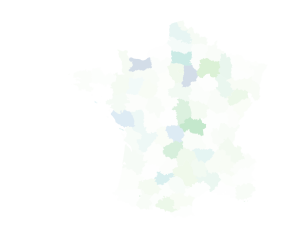

In [5]:
vba_choropleth(y, x, gdf)
plt.show()

You can use the option to bin or classify your `x` and `y` values. `splot` uses mapclassify to bin your data and displays the new color and alpha ranges:

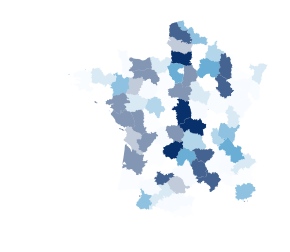

In [6]:
vba_choropleth(y, x, gdf, cmap='Blues',
               rgb_mapclassify=dict(classifier='quantiles', k=3), 
               alpha_mapclassify=dict(classifier='quantiles'))
plt.show()

Instead of using a colormap you can also pass a list of colors:

In [7]:
color_list = ['#a1dab4','#41b6c4','#225ea8']

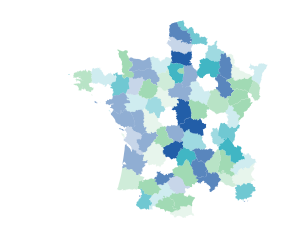

In [8]:
vba_choropleth(y, x, gdf, cmap=color_list,
               rgb_mapclassify=dict(classifier='quantiles', k=3), 
               alpha_mapclassify=dict(classifier='quantiles'))
plt.show()

You can use the `divergent` argument to display divergent alpha values. This means values at the extremes of your data range will be displayed with an alpha value of 1. Values towards the middle of your data range will be mapped more and more invisible towards an alpha value of 0.

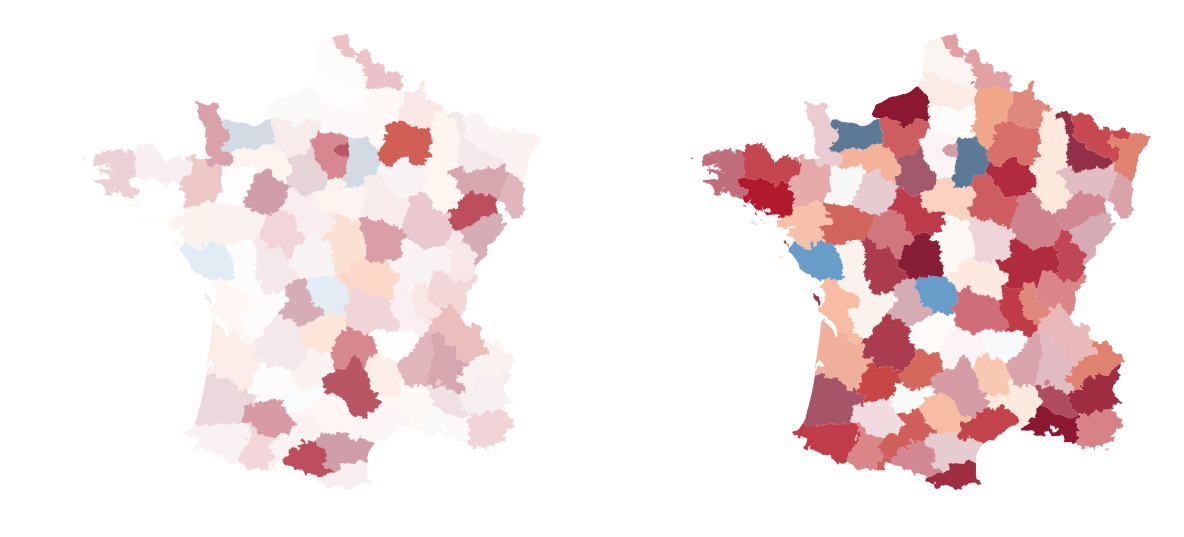

In [9]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
vba_choropleth(y, x, gdf, cmap='RdBu',
               divergent=False, ax=axs[0])
vba_choropleth(y, x, gdf, cmap='RdBu',
               divergent=True, ax=axs[1])
plt.show()

# Create your own cmap for plotting

Sometimes you need to display divergent values with a natural midpoint not overlapping wiht the median of your data. For example if you measure the temperature over a country ranging from -2 to 10 degrees Celsius. Or if you need to assess wether a certain threshold is reached.

For cases like this splot provides a utility function to shift your colormap.

In [10]:
from splot._viz_utils import shift_colormap

In [11]:
mid08 = shift_colormap('RdBu', midpoint=0.8)
mid02 = shift_colormap('RdBu', midpoint=0.2)

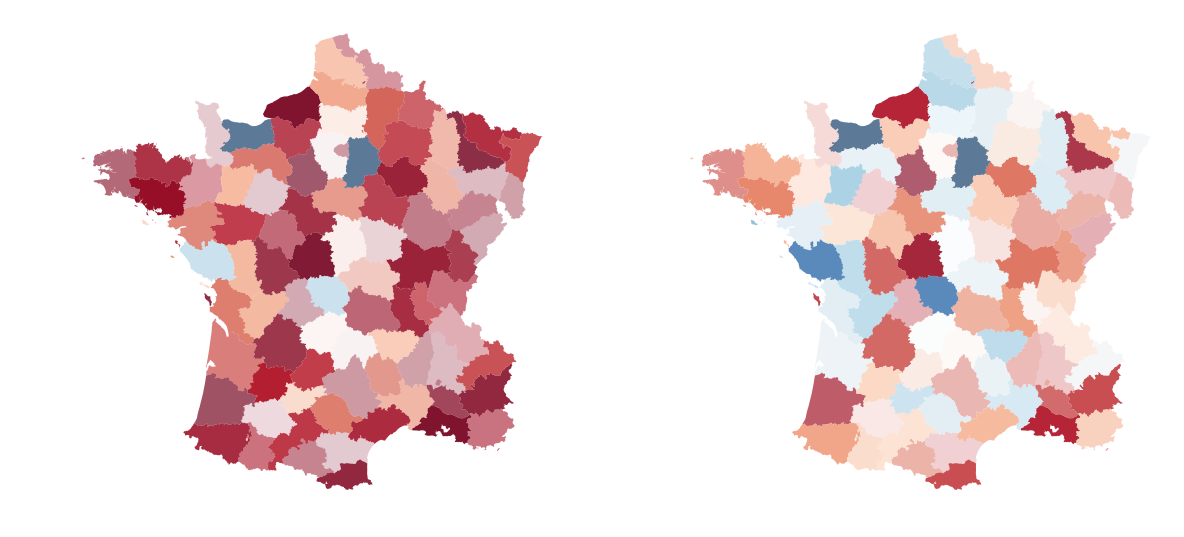

In [12]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
vba_choropleth(y, x, gdf, cmap=mid08, ax=axs[0], divergent=True)
vba_choropleth(y, x, gdf, cmap=mid02, ax=axs[1], divergent=True)
plt.show()

# Add a legend

If your values are classified, you have the option to add a legend to your map.

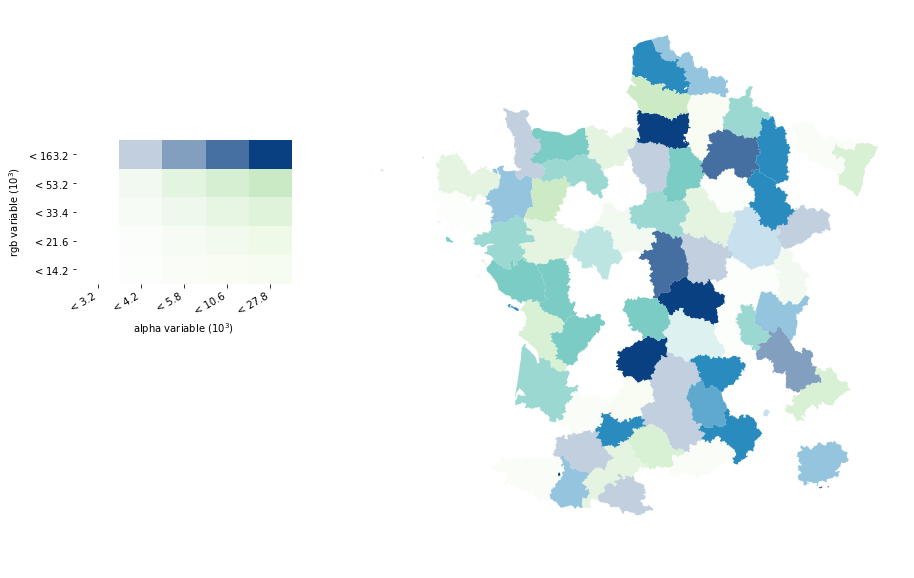

In [21]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
vba_choropleth(x, y, gdf,
               alpha_mapclassify=dict(classifier='quantiles', k=5),
               rgb_mapclassify=dict(classifier='quantiles', k=5),
               legend=True, ax=ax)
plt.show()

# EXAMPLE: US elections

In [13]:
y

array([ 5098,  8901, 10973,  2733,  6962,  3188,  6400,  3542,  3608,
        2582,  3211,  2314, 27830,  4093, 13602, 13254,  9561, 14993,
        2540, 10387, 10997,  4687,  3436,  2829, 11712,  4553, 23945,
        3048,  2286,  2848,  5076,  1680,  7686, 11315,  7254,  4077,
        3012, 12059,  5626,  3446,  2746,  8310,  4753,  5194,  4432,
        2040,  4410,  5179,  3963,  4013,  2107,  3912,  4196, 14739,
        9515, 10452,  6092,  5501,  9242,  5740,  5963,  3299,  6001,
       11644, 14472,  6001,  1983, 11701,  3710,  3357,  4204,  7245,
        5303,  4007, 16956,  4964,  3449,  4558,  2449,  1246, 14035,
        8922, 13817,  4040,  4276])

In [14]:
x

array([ 35039,  12831, 114121,  14238,  16171,  52547,  26198, 123625,
        10989,  66498, 116671,   8107,  31807,  87338,  25720,  16798,
        19497,  47480,  16128,  75056,  77823,  36024,  40690,  23816,
        13493,  15015,  25143,  18292,  56140,  61510,  19220,  30869,
        45180,  25014,  15272,  36275,  34476,  35375,  14417,  71364,
       163241,  27289,  11813,  48783,  38501,  11092,  33358,  55564,
         8334,  19586,  28331,  15652,  13463,  34196,  25572,  29381,
        13851,   5994,  34069,  15400,  78148,  65995, 148039,  37843,
        18623,  21233,  17003,  39714,  22184,  29280,   3632,   9523,
         7315,   3460,  24533,  12836,  68980,  48317,  13380,  19024,
        67963,  21851,  33497,  33029,  12789])

In [16]:
from bdbd

SyntaxError: invalid syntax (<ipython-input-16-d663ccdd2859>, line 1)

In [ ]:
from splot._viz_value_by_alpha_mpl import mapclassify_bin, value_by_alpha_cmap
x_bin = mapclassify_bin(x, 'natural_breaks')
y_bin = mapclassify_bin(y, 'natural_breaks')

In [ ]:
from matplotlib import cm
bla_cmap= cm.RdBu

In [ ]:
rgb_x = bla_cmap((x_bin.bins - x_bin.bins.min()) / (x_bin.bins.max() - x_bin.bins.min()))
rgb_x

In [ ]:
rgba, _ = value_by_alpha_cmap(x_bin.yb, y_bin.yb, cmap=bla_cmap)
np.array(rgba)
rgba.shape

In [ ]:
rgb = rgb_x[:, 0:3]
alpha = rgba[:, 3]
rgb

In [ ]:
alpha_vals = np.unique(alpha)
alpha_vals

In [ ]:
rgb_vals = rgb# np.unique(rgb, axis=0)
rgb_vals

In [ ]:
y_bin

In [ ]:
from matplotlib import patches
fig = plt.figure()
ax = fig.add_subplot(111)
for irow, alpha_val in enumerate(alpha_vals):
    for icol, rgb_val in enumerate(rgb_vals):
        rect = patches.Rectangle((irow, icol), 1, 1, linewidth=3,
                                 edgecolor='none',
                                 facecolor=rgb_val,
                                 alpha=alpha_val)
        ax.add_patch(rect)

ax.plot([], [])
ax.set_xlim([0, irow+1])
ax.set_ylim([0, icol+1])
ax.set_xticklabels(['< %1.2f' % val for val in y_bin.bins])
ax.set_yticklabels(['< %1.2f' % val for val in x_bin.bins])
ax.set_xticks(np.arange(irow+1) + 0.5)
ax.set_yticks(np.arange(icol+1) + 0.5)
ax.set_xlabel('alpha variable')
ax.set_ylabel('rgb variable')

In [ ]:
['%1.2f' % val for val in alpha_vals]

In [ ]:
from splot._viz_value_by_alpha_mpl import _vba_legend

### Data Preparation

In [ ]:
shp_link = examples.get_path("NAT.shp")

In [ ]:
# get shape file
df = gpd.read_file(shp_link)
# and read csv directly from link
vote_table = pd.read_csv("https://gist.github.com/ljwolf/bfc78bdb34f87d741f705eda68793da3/raw/e3a93531fe074ef8a9b322008f24f7fdc9f4ffad/US_County_Level_Presidential_Results_08-16.csv")

In [ ]:
df.shape

In [ ]:
# calculate two-part vote share dem / (dem + repub)
years = [2008, 2012, 2016]
for year in years:
    vote_table[str(year)+'2p_voteshare'] = vote_table["dem_"+str(year)] / (vote_table["dem_"+str(year)] + vote_table["gop_"+str(year)])

In [ ]:
# calculate total count
for year in years:
    vote_table[str(year)+"total_counts"] = vote_table["dem_"+str(year)] + vote_table["gop_"+str(year)]

In [ ]:
vote_table.shape

In [ ]:
vote_table.head()

In [ ]:
# merge
gdf = df.merge(vote_table, left_on='FIPSNO', right_on='fips_code')

# test implication of different shapes and which data is missing
for fips in df['FIPSNO']:
    if not np.any(fips == gdf['fips_code']):
        print('Missing: ', fips)
        print(df[df['FIPSNO'] == fips].head())
        
        
gdf[gdf['NAME'] == 'Clifton Forge']

### Extract data to be plotted and plot

In [ ]:
x = gdf['20162p_voteshare'].values
y = gdf['2016total_counts'].values

In [ ]:
import splot
from splot.mapping import vba_choropleth, value_by_alpha_cmap

In [ ]:
from splot._viz_utils import shift_colormap, truncate_colormap

In [ ]:
cmap = plt.cm.seismic
new_cmap = shift_colormap(cmap, start=0, midpoint=0.2, stop=1)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
vba_choropleth(x, y, gdf, cmap=new_cmap, ax=ax, divergent=False)
plt.show()

In [ ]:
rgba, _ = value_by_alpha_cmap(x, y, cmap=new_cmap, divergent=True)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
gdf.plot(color= rgba, ax=ax)
plt.show()

In [ ]:
import mapclassify

In [ ]:
gdf.plot(column='20162p_voteshare', scheme='quantiles', k=4, legend=True)

In [ ]:
from splot._viz_value_by_alpha_mpl import mapclassify_bin

In [ ]:
alpha_bins = mapclassify_bin(y, classifier='quantiles', k=4)
alpha_bins

In [ ]:
rgb_bins = mapclassify_bin(x, classifier='quantiles', k=4)
rgb_bins

In [ ]:
values_y = alpha_bins.yb
values_y

In [ ]:
values_x = np.array(rgb_bins.yb)

In [ ]:
new_rgba, _cmap=value_by_alpha_cmap(values_x, values_y, divergent = True, cmap='RdBu')

In [ ]:
new_rgba


In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
gdf.plot(color= new_rgba, ax=ax)
plt.show()

In [ ]:
vba_choropleth(values_x, values_y, gdf, cmap='RdBu', divergent=False)